In [ ]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed

from datetime import datetime, timedelta
from dateutil import parser

In [ ]:
#********************#
# Change Required  #
#********************#
folder_path = "/content/drive/MyDrive/USDA/Calving-season-23-data/test/Final-Multi/"

file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv')]


rounded_event_dict = {
    "0BD": "2023/2/11 18:00",
    "0BB": "2023/2/13 19:00",
    "09F": "2023/2/16 16:00",

    "0E7": "2023/2/23 17:00",
    "0BC": "2023/2/26 6:00",
    "12A": "2023/2/27 19:00",

    "13D": "2023/3/7 11:00",
    "0E1": "2023/3/11 19:00",
    "09B": "2023/3/13 19:00",

    "14C": "2023/3/14 2:00",
    "12B": "2023/3/22 19:00",
    "0C5": "2023/3/27 18:00",

    "0BA": "2023/4/1 19:00",
    "0BE": "2023/4/2 14:00",
    "13C": "2023/4/12 0:00"
}


event_duration_dict = {
    "0BD": "-1,1",
    "0BB": "-1,1",
    "09F": "-1,1",

    "0E7": "-1,1",
    "0BC": "-1,1",
    "12A": "-1,1",

    "13D": "-1,1",
    "0E1": "-1,1",
    "09B": "-1,1",

    "14C": "-1,1",
    "12B": "-1,1",
    "0C5": "-1,1",

    "0BA": "-1,1",
    "0BE": "-1,1",
    "13C": "-1,1"
}


In [ ]:
import pandas as pd

for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    collar_id = file_name.split('.')[0][0:3]

#********************#
# Change Required  #
#********************#
    anomaly_file = f"/content/drive/MyDrive/USDA/FinalUpdate/anomalies_maemodel/anomalies_{collar_id}.csv"
    #anomaly_file = f"/content/drive/MyDrive/USDA/FinalUpdate/anomalies_95qt/anomalies_{collar_id}.csv"


    # read csv
    df = pd.read_csv(anomaly_file, parse_dates=['timestamp'])

    # sort all the timestamp
    df = df.sort_values('timestamp').reset_index(drop=True)

    # caculate time gap with the last timestamp
    df['timedelta'] = df['timestamp'].diff().dt.total_seconds() / 3600  # per hour

    # if time gap > 48 hours, create a new cluster
    df['group'] = (df['timedelta'] > 72).cumsum()

    num_groups = df['group'].nunique()

    print(f'total there are {num_groups}  clusters in', collar_id)


total there are 6  clusters in 0BA
total there are 12  clusters in 0BB
total there are 7  clusters in 0BE
total there are 5  clusters in 0E1
total there are 6  clusters in 12B
total there are 6  clusters in 09B
total there are 9  clusters in 0BD
total there are 6  clusters in 0C5
total there are 8  clusters in 0E7
total there are 8  clusters in 12A
total there are 8  clusters in 09F
total there are 7  clusters in 13C
total there are 8  clusters in 0BC
total there are 5  clusters in 13D
total there are 5  clusters in 14C


In [ ]:
def process_event_dataframes(rounded_event_time, duration, df):
    # convert label_time ro datetime without tzinfo
    label_time = parser.parse(rounded_event_time).replace(tzinfo=None)

    # get duration list
    relative_times = [int(x) for x in duration.split(',')]

    # convert Rounded_Time ro datetime without tzinfo
    df['Rounded_Time'] = pd.to_datetime(df['Rounded_Time']).dt.tz_localize(None)

    filtered_df = pd.DataFrame()
    for offset in relative_times:
        if offset > 0:
            start_time = label_time + timedelta(days=offset - 1)
            end_time = start_time + timedelta(days=1)
        else:
            start_time = label_time + timedelta(days=offset)
            end_time = start_time + timedelta(days=1)

        df_filtered = df[(df['Rounded_Time'] >= start_time) & (df['Rounded_Time'] < end_time)]
        filtered_df = pd.concat([filtered_df, df_filtered])

    return filtered_df



In [ ]:
def add_sliding_features(df):
    df = df.copy()
    windows = [6, 12]

    for feat in ['KNN2', 'KNN3', 'KNN4', 'KNN5', 'Distance_moved', 'ActivityCount_Difference']:
        for w in windows:
            df[f'{feat}_MA{w}'] = df[feat].rolling(window=w, min_periods=1).mean()
            df[f'{feat}_STD{w}'] = df[feat].rolling(window=w, min_periods=1).std()
        df[f'{feat}_Diff1'] = df[feat].diff(1)
        df[f'{feat}_Diff3'] = df[feat].diff(3)
    return df


In [ ]:
all_data = pd.DataFrame()


for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path, parse_dates=True, index_col=0)
    collar_id = file_name.split('.')[0][0:3]
    df['collar_id'] = collar_id

#********************#
# Change Required  #
#********************#
    #anomaly_file = f"/content/drive/MyDrive/USDA/FinalUpdate/anomalies/anomalies_{collar_id}.csv"
    #anomaly_file = f"/content/drive/MyDrive/USDA/FinalUpdate/anomalies_95qt/anomalies_{collar_id}.csv"
    anomaly_file = f"/content/drive/MyDrive/USDA/FinalUpdate/anomalies_maemodel/anomalies_{collar_id}.csv"

    # read anomaly_file
    anomaly_df = pd.read_csv(anomaly_file)
    anomaly_times = pd.to_datetime(anomaly_df["timestamp"]).to_list()
    #print(collar_id, len(anomaly_times))
    print(collar_id, df.shape)

    # convert them to be the same format
    anomaly_times = pd.to_datetime(anomaly_times).tz_localize('UTC').round('H')

    # add column: Anomaly (bool)
    df["Anomaly"] = df.index.isin(anomaly_times)

    df = df.reset_index()

    # filter event data (Calving related)
    rounded_event_time = rounded_event_dict[collar_id]
    duration = event_duration_dict[collar_id]
    filtered_df = process_event_dataframes(rounded_event_time, duration, df)

    # add Calving label in df_merged
    df['Calving'] = df['Rounded_Time'].isin(filtered_df['Rounded_Time'])

    all_data = pd.concat([all_data, df])

0BA (1876, 8)
0BB (2358, 8)
0BE (1885, 8)
0E1 (1886, 8)
12B (1880, 8)


<ipython-input-7-10f2c4150f07>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomaly_times = pd.to_datetime(anomaly_times).tz_localize('UTC').round('H')
<ipython-input-7-10f2c4150f07>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomaly_times = pd.to_datetime(anomaly_times).tz_localize('UTC').round('H')
<ipython-input-7-10f2c4150f07>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomaly_times = pd.to_datetime(anomaly_times).tz_localize('UTC').round('H')
<ipython-input-7-10f2c4150f07>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomaly_times = pd.to_datetime(anomaly_times).tz_localize('UTC').round('H')
<ipython-input-7-10f2c4150f07>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomaly_times = pd.to

09B (1890, 8)
0BD (2415, 8)
0C5 (1890, 8)
0E7 (2410, 8)


<ipython-input-7-10f2c4150f07>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomaly_times = pd.to_datetime(anomaly_times).tz_localize('UTC').round('H')
<ipython-input-7-10f2c4150f07>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomaly_times = pd.to_datetime(anomaly_times).tz_localize('UTC').round('H')
<ipython-input-7-10f2c4150f07>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomaly_times = pd.to_datetime(anomaly_times).tz_localize('UTC').round('H')
<ipython-input-7-10f2c4150f07>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomaly_times = pd.to_datetime(anomaly_times).tz_localize('UTC').round('H')


12A (2358, 8)
09F (2402, 8)
13C (1882, 8)
0BC (2409, 8)


<ipython-input-7-10f2c4150f07>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomaly_times = pd.to_datetime(anomaly_times).tz_localize('UTC').round('H')
<ipython-input-7-10f2c4150f07>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomaly_times = pd.to_datetime(anomaly_times).tz_localize('UTC').round('H')
<ipython-input-7-10f2c4150f07>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomaly_times = pd.to_datetime(anomaly_times).tz_localize('UTC').round('H')
<ipython-input-7-10f2c4150f07>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomaly_times = pd.to_datetime(anomaly_times).tz_localize('UTC').round('H')


13D (2405, 8)
14C (1882, 8)


<ipython-input-7-10f2c4150f07>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomaly_times = pd.to_datetime(anomaly_times).tz_localize('UTC').round('H')
<ipython-input-7-10f2c4150f07>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomaly_times = pd.to_datetime(anomaly_times).tz_localize('UTC').round('H')


In [ ]:
all_data

,Rounded_Time,KNN2,KNN3,KNN4,KNN5,payload.activityCount,Distance_moved,ActivityCount_Difference,collar_id,Anomaly,Calving
0,2023-02-11 01:00:00,42.235627,68.053618,85.117704,90.915556,126356.0,NaN,NaN,0BA,False,False
1,2023-02-11 02:00:00,26.534464,38.792867,55.289131,95.474752,127295.0,1509.722166,939.0,0BA,False,False
2,2023-02-11 03:00:00,14.888552,62.427295,72.221390,87.032175,127934.0,766.686967,639.0,0BA,False,False
3,2023-02-11 04:00:00,62.494391,97.971414,130.540610,151.805413,128534.0,468.917304,600.0,0BA,False,False
4,2023-02-11 05:00:00,28.566777,42.232035,57.564835,63.791684,128848.0,188.322535,314.0,0BA,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1877,2023-04-30 20:00:00,7.738556,14.670781,16.734895,18.533585,732547.0,1519.031831,803.0,14C,False,False
1878,2023-04-30 21:00:00,5.578300,6.177862,8.870257,9.175761,732588.0,11.156596,41.0,14C,False,False
1879,2023-04-30 22:00:00,7.738558,7.738558,14.232970,14.670781,732628.0,9.175761,40.0,14C,False,False
1880,2023-04-30 23:00:00,6.177860,14.433676,20.287295,22.326006,732653.0,16.537495,25.0,14C,False,False


In [ ]:
all_data = add_sliding_features(all_data)

In [ ]:
anomaly_data = all_data[all_data["Anomaly"] == True]

In [ ]:
anomaly_data

,Rounded_Time,KNN2,KNN3,KNN4,KNN5,payload.activityCount,Distance_moved,ActivityCount_Difference,collar_id,Anomaly,...,Distance_moved_MA12,Distance_moved_STD12,Distance_moved_Diff1,Distance_moved_Diff3,ActivityCount_Difference_MA6,ActivityCount_Difference_STD6,ActivityCount_Difference_MA12,ActivityCount_Difference_STD12,ActivityCount_Difference_Diff1,ActivityCount_Difference_Diff3
353,2023-02-25 19:00:00,13.469672,14.723046,24.154984,122.860852,222521.0,2475.811946,1316.0,0BA,True,...,440.189759,756.902723,1054.133816,2019.371348,676.333333,368.033513,358.000000,417.833808,529.0,856.0
354,2023-02-25 20:00:00,4.797338,5.578310,5.693188,10.008041,223726.0,2374.696698,1205.0,0BA,True,...,633.150589,926.981956,-101.115248,2210.731978,822.666667,375.823718,442.583333,478.992211,-111.0,808.0
389,2023-02-27 07:00:00,27.356757,56.402990,65.498592,66.316530,235906.0,3.722319,117.0,0BA,True,...,303.427260,376.455103,-42.527349,1.323866,266.166667,325.047945,420.083333,363.755527,-42.0,113.0
425,2023-02-28 19:00:00,28.287581,471.163991,478.083283,481.884293,247307.0,68.988685,419.0,0BA,True,...,197.115103,202.277883,-427.329153,-497.799000,510.166667,86.367625,335.833333,241.749620,-16.0,-188.0
510,2023-03-04 09:00:00,25.619346,25.856586,65.515583,67.590182,274883.0,6.177806,185.0,0BA,True,...,182.706881,211.715516,-100.511778,3.331212,132.000000,83.330667,303.583333,258.765411,-60.0,164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,2023-04-24 19:00:00,64.958953,207.293079,212.611007,487.840217,685721.0,37.083373,391.0,14C,True,...,106.809537,111.649604,-0.590258,-43.284031,572.500000,118.630097,347.500000,270.190673,-140.0,-257.0
1756,2023-04-25 17:00:00,35.480986,71.519437,245.938785,284.821122,692213.0,6.177845,317.0,14C,True,...,80.571102,117.568222,-92.195602,-415.222224,399.833333,249.749808,244.500000,242.365051,-189.0,-388.0
1780,2023-04-26 17:00:00,24.579338,25.688009,47.899281,1406.546871,700259.0,34.159129,459.0,14C,True,...,176.306750,306.715948,-200.747822,-910.941617,417.166667,302.235284,291.750000,268.488065,-169.0,-377.0
1781,2023-04-26 18:00:00,20.495413,23.272484,76.013996,1522.588328,700332.0,10.007190,73.0,14C,True,...,176.675853,306.494401,-24.151939,-26.716397,428.000000,285.327882,293.916667,266.430430,-386.0,-84.0


In [ ]:
# # time encoding
# hour_f = anomaly_data["Rounded_Time"].dt.hour + anomaly_data["Rounded_Time"].dt.minute / 60
# anomaly_data["sin_hour"] = np.sin(2 * np.pi * hour_f / 24)
# anomaly_data["cos_hour"] = np.cos(2 * np.pi * hour_f / 24)

# hour_f

# anomaly_data

<ipython-input-24-1f33deca510f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomaly_data["sin_hour"] = np.sin(2 * np.pi * hour_f / 24)
<ipython-input-24-1f33deca510f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomaly_data["cos_hour"] = np.cos(2 * np.pi * hour_f / 24)


In [ ]:
calving_counts = anomaly_data[anomaly_data['Calving'] == True].groupby('collar_id').size()
print(calving_counts)

collar_id
09B    14
09F    17
0BA    14
0BB    16
0BC    19
0BD    22
0BE    15
0C5     9
0E1    11
0E7    21
12A     6
12B    17
13C    19
13D    13
14C    13
dtype: int64


In [ ]:
def calculate_precision_recall_f1(df, true_label_time, cluster_threshold=72, tp_threshold=24):
    """
    Parameters:
    - df: DataFrame, contains 'Rounded_Time' and 'y_pred' columns.
    - true_label_time: String, single true label time (format: 'YYYY/MM/DD HH:MM').
    - cluster_threshold: int, cluster interval threshold in hours (default: 48).
    - tp_threshold: int, time window threshold for determining TP in hours (default: 24).

    Returns:
    - metrics: dict, including Precision, Recall, F1 Score。
    """

    true_label_time = pd.to_datetime(true_label_time)

    # get all y_pred==True
    predicted_times = df.loc[df['y_pred'] == True, 'Rounded_Time']
    if predicted_times.empty:
        return {
            'Precision': 0.0,
            'Recall': 0.0,
            'F1 Score': 0.0,
            'TP Clusters': 0,
            'Total Clusters': 0,
            'Time_Gap': None,
        }

    predicted_times = pd.to_datetime(predicted_times).sort_values()

    # clustering
    clusters = []
    current_cluster = [predicted_times.iloc[0]]
    for i in range(1, len(predicted_times)):
        if (predicted_times.iloc[i] - current_cluster[-1]).total_seconds() / 3600 <= cluster_threshold:
            current_cluster.append(predicted_times.iloc[i])
        else:
            clusters.append(current_cluster)
            current_cluster = [predicted_times.iloc[i]]
    clusters.append(current_cluster)

    # count TP
    tp_count = 0
    time_diff = None
    for cluster in clusters:
        # Find the closest prediction point to the true label in the cluster
        closest_point = min(cluster, key=lambda x: abs((x - true_label_time).total_seconds()))
        time_diff = abs((closest_point - true_label_time).total_seconds() / 3600)  # 转换为小时

        # whether this cluster is TP
        if time_diff <= tp_threshold:
            tp_count += 1
            break  # 1 TP point means this cluster is TP

    # Precision, Recall, F1 Score
    precision = tp_count / len(clusters) if clusters else 0.0
    recall = tp_count / 1  # Since each cow has only 1 calving event, tp_count / 1 is recall
    f1_score = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0.0

    return {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'TP Clusters': tp_count,
        'Total Clusters': len(clusters),
        'Time_Gap': time_diff,
    }


In [ ]:
# k-fold cross validation
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import KFold
import joblib


collars = anomaly_data['collar_id'].unique()  # get all collar_ids
results = []

random.seed(21)

kf = KFold(n_splits=5, shuffle=True, random_state=21)

for fold, (train_idx, test_idx) in enumerate(kf.split(collars)):
    train_collars = collars[train_idx]
    test_collars = collars[test_idx]

    print(f"Fold {fold + 1}")
    print("Train:", train_collars)
    print("Test:", test_collars)

    # train test split
    train_data = anomaly_data[anomaly_data['collar_id'].isin(train_collars)]
    test_data = anomaly_data[anomaly_data['collar_id'].isin(test_collars)]

    # features, X_train, y_train, X_test, y_test
    #features = ['KNN2', 'KNN3', 'KNN4', 'KNN5', 'Distance_moved', 'ActivityCount_Difference']
    features = [col for col in anomaly_data.columns if any(key in col for key in [
        'KNN', 'Distance_moved', 'ActivityCount'
    ])]
    X_train = train_data[features]
    y_train = train_data['Calving'].astype(bool)
    X_test = test_data[features]
    y_test = test_data['Calving'].astype(bool)

    # training
    clf = RandomForestClassifier(n_estimators=100, random_state=21, class_weight='balanced')
    clf.fit(X_train, y_train)

    # y_pred
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))

    # split the test data by different cows
    test_data['y_pred'] = y_pred
    grouped = test_data.groupby("collar_id")
    grouped_test = {collar_id: group for collar_id, group in grouped}

    # metrics for each cow (clustering)
    for c_id in test_collars:
        test_df = grouped_test[c_id]
        metrics = calculate_precision_recall_f1(test_df, rounded_event_dict[c_id])
        print(f"Collar ID: {c_id}, Metrics: {metrics}")

        results.append({
            'Fold': fold + 1,
            'collar_id': c_id,
            **metrics
        })

#********************#
# Change Required  #
#********************#
    # save the model
    clf_name = f"Fold{fold+1}.pkl"
    joblib.dump(clf, '/content/drive/MyDrive/USDA/FinalUpdate/clf_models/' + clf_name)

# save
results_df = pd.DataFrame(results)
#********************#
# Change Required  #
#********************#
results_df.to_csv('/content/sample_data/RandomForest-RandomSampling-with-Clusters.csv', index=False)

summary = results_df.groupby('collar_id').agg({
    'Precision': ['mean'],
    'Recall': ['mean'],
    'F1 Score': ['mean'],
    'Time_Gap': ['mean']
}).reset_index()

summary



Fold 1
Train: ['0BA' '0BB' '0BE' '0E1' '12B' '0BD' '0E7' '12A' '09F' '13C' '0BC' '13D']
Test: ['09B' '0C5' '14C']
              precision    recall  f1-score   support

       False       0.89      1.00      0.94       248
        True       1.00      0.17      0.29        36

    accuracy                           0.89       284
   macro avg       0.95      0.58      0.61       284
weighted avg       0.91      0.89      0.86       284

Collar ID: 09B, Metrics: {'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'TP Clusters': 1, 'Total Clusters': 1, 'Time_Gap': 0.0}
Collar ID: 0C5, Metrics: {'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'TP Clusters': 0, 'Total Clusters': 0, 'Time_Gap': None}
Collar ID: 14C, Metrics: {'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'TP Clusters': 0, 'Total Clusters': 0, 'Time_Gap': None}


<ipython-input-14-da9f5c262071>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['y_pred'] = y_pred


Fold 2
Train: ['0BA' '0BE' '0E1' '12B' '09B' '0C5' '0E7' '12A' '13C' '0BC' '13D' '14C']
Test: ['0BB' '0BD' '09F']
              precision    recall  f1-score   support

       False       0.93      0.98      0.95       304
        True       0.82      0.60      0.69        55

    accuracy                           0.92       359
   macro avg       0.88      0.79      0.82       359
weighted avg       0.91      0.92      0.91       359

Collar ID: 0BB, Metrics: {'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'TP Clusters': 1, 'Total Clusters': 1, 'Time_Gap': 8.0}
Collar ID: 0BD, Metrics: {'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'TP Clusters': 1, 'Total Clusters': 1, 'Time_Gap': 3.0}
Collar ID: 09F, Metrics: {'Precision': 0.5, 'Recall': 1.0, 'F1 Score': 0.6666666666666666, 'TP Clusters': 1, 'Total Clusters': 2, 'Time_Gap': 2.0}


<ipython-input-14-da9f5c262071>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['y_pred'] = y_pred


Fold 3
Train: ['0BA' '0BB' '12B' '09B' '0BD' '0C5' '0E7' '12A' '09F' '13C' '13D' '14C']
Test: ['0BE' '0E1' '0BC']
              precision    recall  f1-score   support

       False       0.90      0.99      0.94       266
        True       0.85      0.38      0.52        45

    accuracy                           0.90       311
   macro avg       0.88      0.68      0.73       311
weighted avg       0.90      0.90      0.88       311

Collar ID: 0BE, Metrics: {'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'TP Clusters': 1, 'Total Clusters': 1, 'Time_Gap': 2.0}
Collar ID: 0E1, Metrics: {'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'TP Clusters': 1, 'Total Clusters': 1, 'Time_Gap': 5.0}
Collar ID: 0BC, Metrics: {'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'TP Clusters': 1, 'Total Clusters': 1, 'Time_Gap': 3.0}


<ipython-input-14-da9f5c262071>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['y_pred'] = y_pred


Fold 4
Train: ['0BB' '0BE' '0E1' '12B' '09B' '0BD' '0C5' '0E7' '12A' '09F' '0BC' '14C']
Test: ['0BA' '13C' '13D']
              precision    recall  f1-score   support

       False       0.88      0.98      0.93       263
        True       0.71      0.26      0.38        46

    accuracy                           0.87       309
   macro avg       0.79      0.62      0.66       309
weighted avg       0.86      0.87      0.85       309

Collar ID: 0BA, Metrics: {'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'TP Clusters': 1, 'Total Clusters': 1, 'Time_Gap': 0.0}
Collar ID: 13C, Metrics: {'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'TP Clusters': 1, 'Total Clusters': 1, 'Time_Gap': 14.0}
Collar ID: 13D, Metrics: {'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'TP Clusters': 1, 'Total Clusters': 1, 'Time_Gap': 5.0}


<ipython-input-14-da9f5c262071>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['y_pred'] = y_pred


Fold 5
Train: ['0BA' '0BB' '0BE' '0E1' '09B' '0BD' '0C5' '09F' '13C' '0BC' '13D' '14C']
Test: ['12B' '0E7' '12A']
              precision    recall  f1-score   support

       False       0.87      0.88      0.87       289
        True       0.14      0.14      0.14        44

    accuracy                           0.78       333
   macro avg       0.51      0.51      0.51       333
weighted avg       0.77      0.78      0.78       333

Collar ID: 12B, Metrics: {'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'TP Clusters': 1, 'Total Clusters': 1, 'Time_Gap': 14.0}
Collar ID: 0E7, Metrics: {'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'TP Clusters': 1, 'Total Clusters': 1, 'Time_Gap': 3.0}
Collar ID: 12A, Metrics: {'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'TP Clusters': 0, 'Total Clusters': 1, 'Time_Gap': 47.0}


<ipython-input-14-da9f5c262071>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['y_pred'] = y_pred


,collar_id,Precision,Recall,F1 Score,Time_Gap
,,mean,mean,mean,mean
0,09B,1.0,1.0,1.000000,0.0
1,09F,0.5,1.0,0.666667,2.0
2,0BA,1.0,1.0,1.000000,0.0
3,0BB,1.0,1.0,1.000000,8.0
4,0BC,1.0,1.0,1.000000,3.0
5,0BD,1.0,1.0,1.000000,3.0
6,0BE,1.0,1.0,1.000000,2.0
7,0C5,0.0,0.0,0.000000,NaN
8,0E1,1.0,1.0,1.000000,5.0


In [ ]:
import joblib

# save the model
clf_name = "show_demo.pkl"
#********************#
# Change Required  #
#********************#
joblib.dump(clf, '/content/drive/MyDrive/USDA/FinalUpdate/clf_models/' + clf_name)

['/content/drive/MyDrive/USDA/FinalUpdate/clf_models/show_demo.pkl']

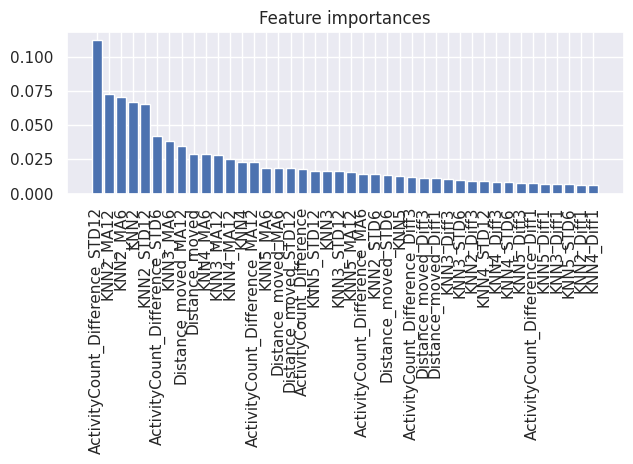

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# get feature importances
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# visualization
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()